In [ ]:
!pip install emoji

In [ ]:
import pandas as pd
import re

import regex
import emoji

import numpy as np
from collections import Counter

import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display
from nltk.util import ngrams

# Configuración inicial

In [ ]:

# Patron regex para identificar el comienzo de cada línea del txt con la fecha y la hora
def IniciaConFechaYHora(s):
    patron = '^\[\d{2}/\d{2}/\d{2}, \d{1,2}:\d{2}:\d{2}\s[ap]\.\sm\.\]\s.*:'
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de fecha y hora
    return bool(resultado)

# Separar las partes de cada línea del txt: Fecha, Hora, Miembro y Mensaje
def ObtenerPartes(linea):
    splitLinea = linea.split('] ', 1)  # Separar la fecha y hora del resto del mensaje
    FechaHora = splitLinea[0][1:]  # Eliminar '[' al principio
    splitFechaHora = FechaHora.split(', ')
    Fecha = splitFechaHora[0]  # '28/11/23'
    Hora = splitFechaHora[1]   # '10:20:29 p. m.'
    splitMensaje = splitLinea[1].split(': ', 1)  # Separar el emisor del mensaje
    Miembro = splitMensaje[0]  # 'Julián Loaiza'
    Mensaje = splitMensaje[1]  # 'Texto del mensaje'
    return Fecha, Hora, Miembro, Mensaje

Obtener el dataframe usando el archivo txt y las funciones definidas

In [ ]:
# Leer el archivo txt descargado del chat de WhatsApp
RutaChat = 'sample_data/pandebono.txt'

# Lista para almacenar los datos (Fecha, Hora, Miembro, Mensaje) de cada línea del txt
DatosLista = []
with open(RutaChat, encoding="utf-8") as fp:
    fp.readline() # Eliminar primera fila relacionada al cifrado de extremo a extremo
    Fecha, Hora, Miembro = None, None, None
    while True:
        linea = fp.readline()
        if not linea:
            break
        linea = linea.strip()
        if IniciaConFechaYHora(linea): # Si cada línea del txt coincide con el patrón fecha y hora
            Fecha, Hora, Miembro, Mensaje = ObtenerPartes(linea) # Obtener datos de cada línea del txt
            DatosLista.append([Fecha, Hora, Miembro, Mensaje])

# Convertir la lista con los datos a dataframe
df = pd.DataFrame(DatosLista, columns=['Fecha', 'Hora', 'Miembro', 'Mensaje'])

# Cambiar la columna Fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%d/%m/%y")

# Eliminar los posibles campos vacíos del dataframe
# y lo que no son mensajes como cambiar el asunto del grupo o agregar a alguien
df = df.dropna()

# Resetear el índice
df.reset_index(drop=True, inplace=True)

#### Filtrar el chat por fecha de acuerdo a lo requerido

In [ ]:
start_date = '2023-06-01'
end_date = '2023-11-30'

df = df[(df['Fecha'] >= start_date) & (df['Fecha'] <= end_date)]
df

,Fecha,Hora,Miembro,Mensaje
2,2023-06-29,6:25:36 p. m.,Diego Vinasco,imagen omitida
3,2023-06-29,6:26:08 p. m.,Diego Vinasco,???????????
4,2023-06-29,6:26:09 p. m.,Diego Vinasco,GTA V
5,2023-06-29,6:26:18 p. m.,Diego Vinasco,AHHH MK
6,2023-06-29,6:26:22 p. m.,Diego Vinasco,YA ESTAMOS EN REBAJAS DE VERANO
...,...,...,...,...
17809,2023-11-29,10:48:42 a. m.,Agustín Valencia,@573053494362 qué opina?
17810,2023-11-29,10:49:19 a. m.,Ivan Bedoya,"esa vieja cree en el horozcopo , ella si le en..."
17811,2023-11-29,10:49:20 a. m.,Ivan Bedoya,:V
17812,2023-11-29,10:51:31 a. m.,Jeff A,Qué putas?


# Estadísticas individuales  y grupales


#### Total de mensajes, multimedia, emojis y links enviados

In [ ]:
# Función para obtener emojis de un mensaje
def ObtenerEmojis(Mensaje):
    emoji_lista = []
    data = regex.findall(r'\X', Mensaje)
    for caracter in data:
        if caracter in emoji.EMOJI_DATA:
            emoji_lista.append(caracter)
    return emoji_lista

# Aplicar la función para obtener emojis
df['Emojis'] = df['Mensaje'].apply(ObtenerEmojis)

# Patrón para identificar URLs
url_patron = r'(https?://\S+)'
df['URLs'] = df.Mensaje.apply(lambda x: len(re.findall(url_patron, x)))

# Agrupar por miembro y calcular estadísticas
estadisticas_por_miembro = df.groupby('Miembro').agg(
    Total_Mensajes=('Mensaje', 'count'),
    Fotos=('Mensaje', lambda x: (x == 'imagen omitida').sum()),
    Videos=('Mensaje', lambda x: (x == 'Video omitido').sum()),
    Audios=('Mensaje', lambda x: (x == 'audio omitido').sum()),
    Stickers=('Mensaje', lambda x: (x == 'sticker omitido').sum()),
    Total_Emojis=('Emojis', lambda x: sum(len(e) for e in x)),
    Total_Links=('URLs', 'sum'),
)

# Resetear el índice del DataFrame
df.reset_index(drop=True, inplace=True)

# Calcular estadísticas globales
estadisticas_globales = {
    'Total_Mensajes': len(df),
    'Fotos': (df['Mensaje'] == 'imagen omitida').sum(),
    'Videos': (df['Mensaje'] == 'Video omitido').sum(),
    'Audios': (df['Mensaje'] == 'audio omitido').sum(),
    'Estickers': (df['Mensaje'] == 'sticker omitido').sum(),
    'Total_Emojis': sum(len(e) for e in df['Emojis']),
    'Total_Links': df['URLs'].sum(),
}

# Mostrar el DataFrame global de emojis más usados
print("Estadísticas Globales:")
display(estadisticas_globales)

# Mostrar el DataFrame de emojis por miembro
print("\nEstadísticas por Miembro:")
display(estadisticas_por_miembro)

Estadísticas Globales:


{'Total_Mensajes': 17812,
 'Fotos': 853,
 'Videos': 307,
 'Audios': 31,
 'Estickers': 1295,
 'Total_Emojis': 395,
 'Total_Links': 136}


Estadísticas por Miembro:


,Total_Mensajes,Fotos,Videos,Audios,Stickers,Total_Emojis,Total_Links
Miembro,,,,,,,
Agustín Valencia,3183,215,110,1,413,40,5
Camilo Anonimo,1575,43,3,2,76,11,23
Cristian Chia,332,1,0,1,28,50,0
Diego Vinasco,4004,183,82,4,491,87,24
Ivan Bedoya,4988,228,91,15,109,36,57
Jeff A,1036,37,0,4,104,51,5
Juan Ariza,326,36,4,1,14,26,0
Juan Pablo Juanpagim,1964,103,17,3,46,52,21
Julián Loaiza,368,6,0,0,9,35,0


#### Emojis más usados

In [ ]:
# Función para contar emojis y devolver los más comunes
def contar_emojis(lista_emojis):
    emoji_contados = Counter(lista_emojis)
    emoji_mas_usados = emoji_contados.most_common(5)  # Ajusta el número para mostrar más/menos emojis
    return emoji_mas_usados

# Agrupar por miembro, concatenar emojis y contar
emojis_por_miembro = df.groupby('Miembro')['Emojis'].sum().apply(contar_emojis)

# Crear DataFrame con los resultados por miembro
emojis_mas_usados_por_miembro = pd.DataFrame(emojis_por_miembro).reset_index()

# Dar formato a la columna de emojis por miembro
emojis_mas_usados_por_miembro['Emojis'] = emojis_mas_usados_por_miembro['Emojis'].apply(lambda x: ', '.join([f'{emoji}({count})' for emoji, count in x]))

# Calcular estadísticas globales de emojis
emojis_globales = df['Emojis'].sum()
emojis_mas_usados_globales = contar_emojis(emojis_globales)

# Crear DataFrame con los resultados globales
emojis_mas_usados_globales_df = pd.DataFrame(emojis_mas_usados_globales, columns=['Emoji', 'Count'])

# Mostrar el DataFrame global de emojis más usados
print("\nEstadísticas Globales de Emojis:")
display(emojis_mas_usados_globales_df)

# Mostrar el DataFrame de emojis por miembro
print("Estadísticas de Emojis por Miembro:")
display(emojis_mas_usados_por_miembro)


Estadísticas Globales de Emojis:


,Emoji,Count
0,😂,40
1,😴,36
2,😈,22
3,🤢,21
4,😎,18


Estadísticas de Emojis por Miembro:


,Miembro,Emojis
0,Agustín Valencia,"🚩(15), 🪬(11), 💤(5), 🤢(2), 😴(1)"
1,Camilo Anonimo,"👀(4), 📸(2), 😂(1), 🐔(1), 🍐(1)"
2,Cristian Chia,"😈(20), 😠(6), 😭(5), 🤬(3), 😞(2)"
3,Diego Vinasco,"😴(17), ♿(16), 🙏(15), 😎(7), 🤢(5)"
4,Ivan Bedoya,"😎(10), 👀(6), 🫓(5), 🤢(4), 🐕(3)"
5,Jeff A,"😴(18), 🤢(7), 😘(3), 🧐(3), 🙏🏻(2)"
6,Juan Ariza,"😂(4), 😡(2), 😞(2), 😭(2), 🧢(1)"
7,Juan Pablo Juanpagim,"😂(27), 🤡(5), 😒(2), 🇦🇷(2), 📄(1)"
8,Julián Loaiza,"😂(5), 😩(4), 😜(3), 🤣(3), 🤑(2)"
9,~ Cristhian M.,"💔(2), 🧐(1), 😞(1), 😔(1), 😭(1)"


#### Número de mensajes a través del tiempo

In [ ]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por día'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('Fecha').sum()
date_df.reset_index(inplace=True)

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='Fecha', y='# Mensajes por día')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Cantidad de mensajes vs Tiempo',
             'y':0.96,
             'x':0.5,
             'xanchor': 'center'},
    font=dict(size=17))
fig.update_xaxes(tickangle=45, nticks=35)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

<ipython-input-8-d6628047053b>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  date_df = df.groupby('Fecha').sum()


###Rango de hora donde hay más mensajes

In [ ]:
df['rangoHora'] = pd.to_datetime(df['Hora'])

# Define a function to create the "Range Hour" column
def create_range_hour(hour):
    start_hour = hour.hour
    end_hour = (hour + pd.Timedelta(hours=1)).hour
    return f'{start_hour:02d} - {end_hour:02d} h'

# Apply the function to create the "Range Hour" column
df['rangoHora'] = df['rangoHora'].apply(create_range_hour)
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por hora'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('rangoHora').sum()
date_df.reset_index(inplace=True)

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='rangoHora', y='# Mensajes por hora')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Cantidad de mensajes vs Tiempo',
             'y':0.96,
             'x':0.5,
             'xanchor': 'center'},
    font=dict(size=17))
fig.update_xaxes(title_text='Rango de hora', tickangle=30)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

<ipython-input-9-0c986f880746>:15: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



### Palabras más usadas

<ipython-input-10-02906af3f49d>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-10-02906af3f49d>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



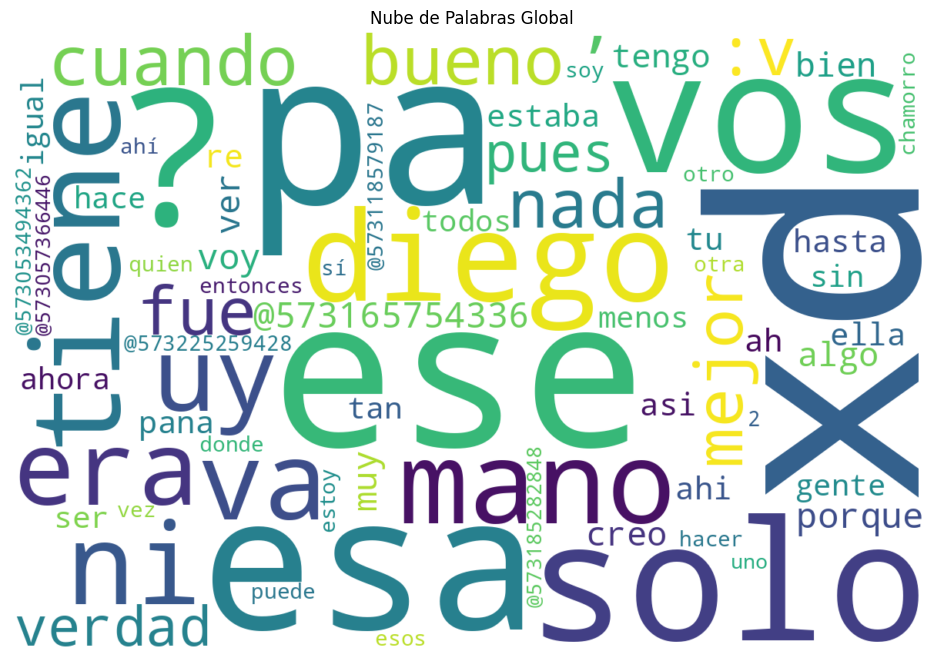

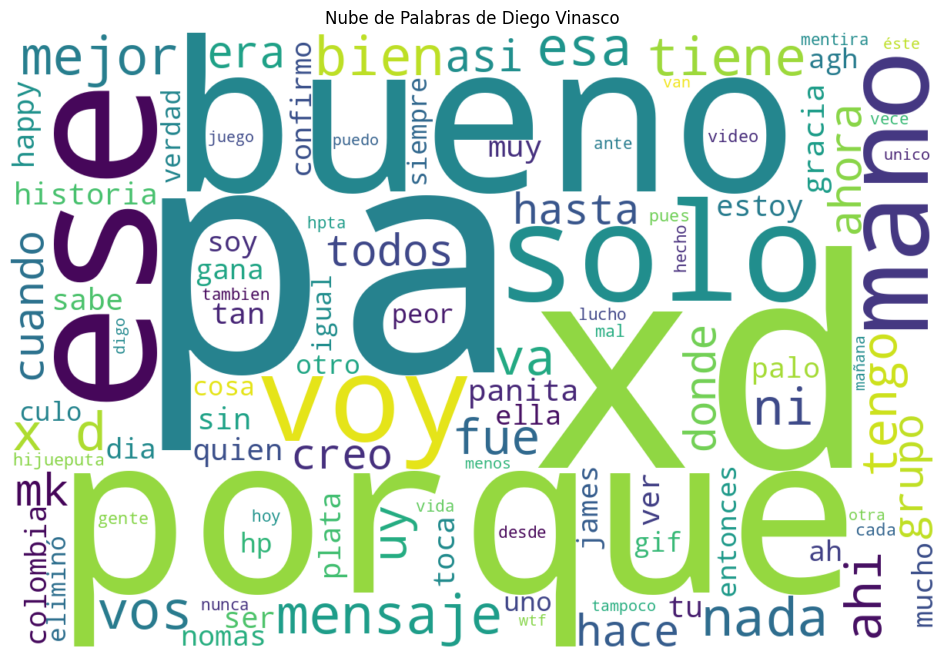

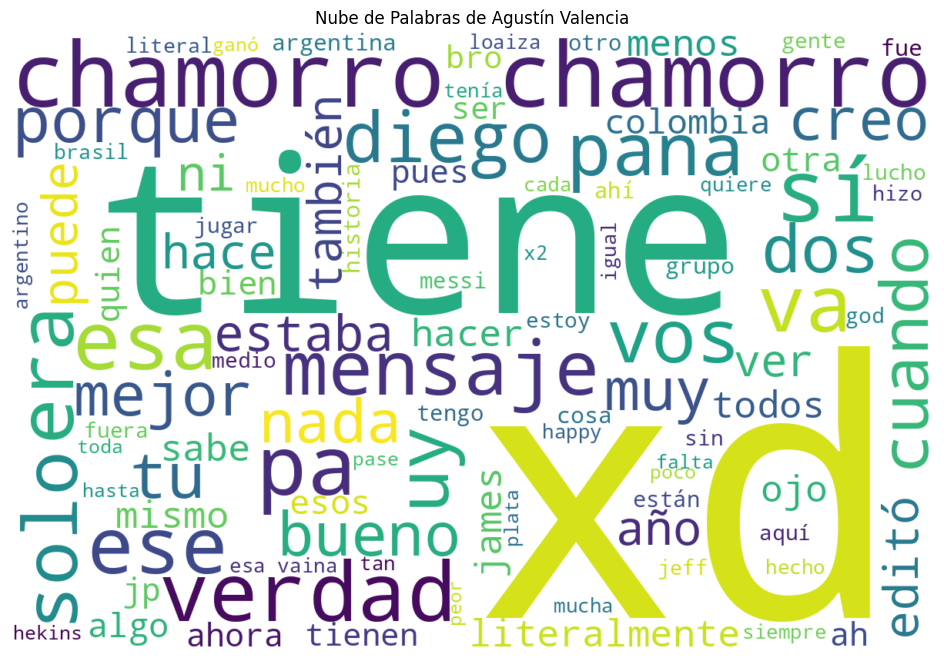

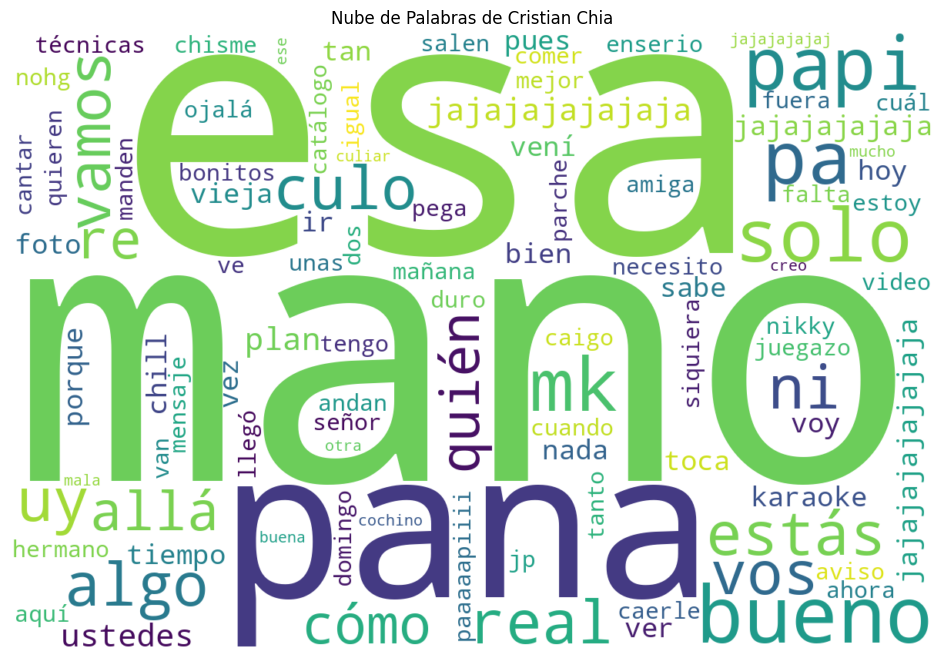

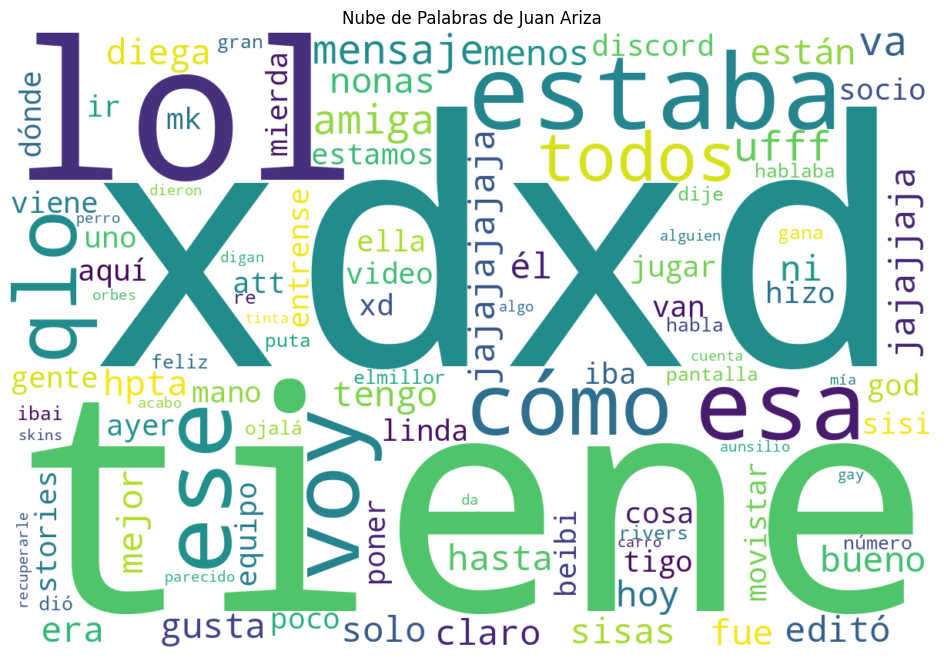

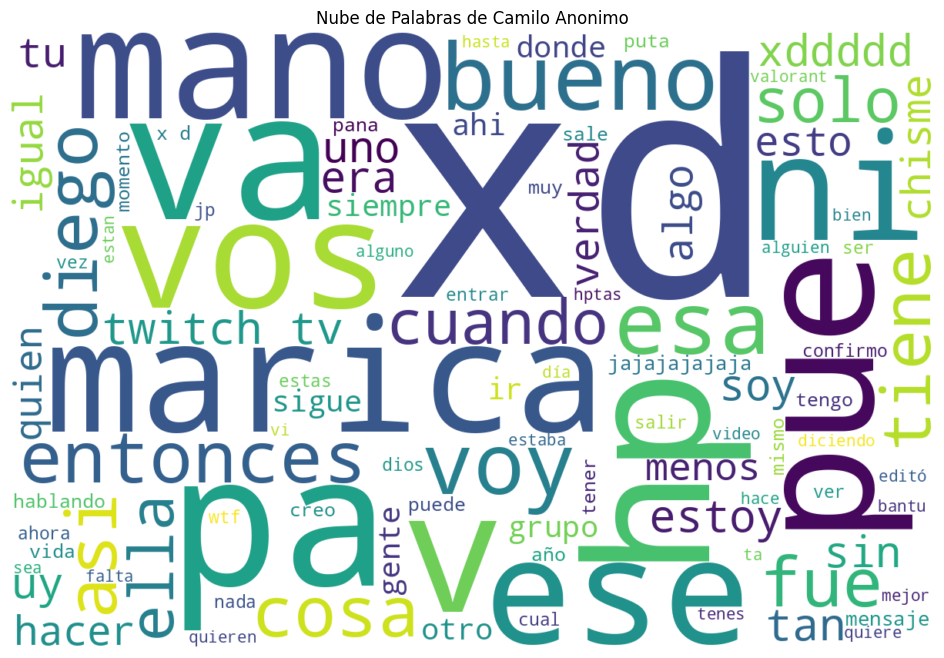

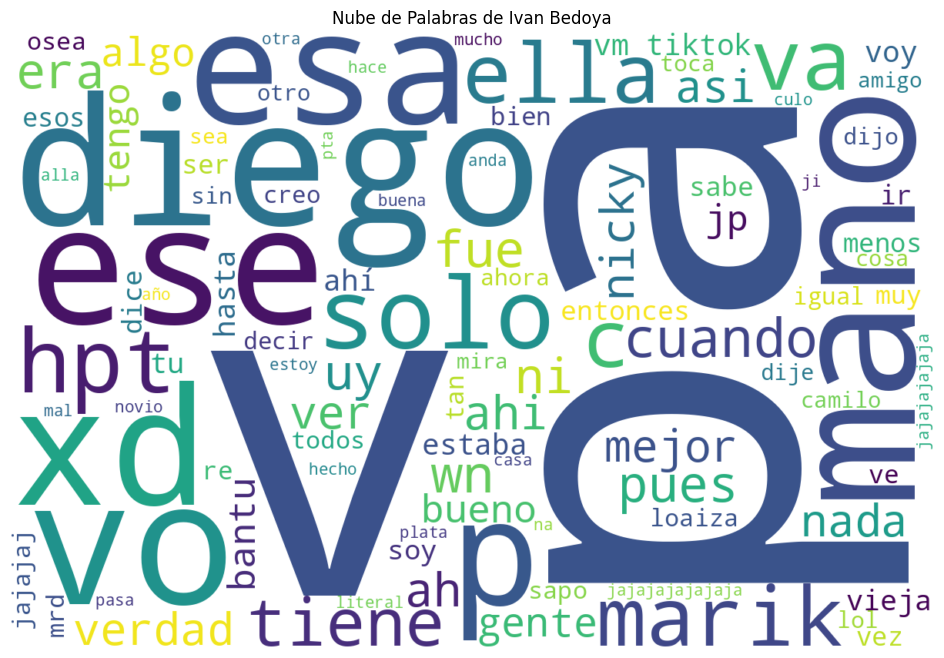

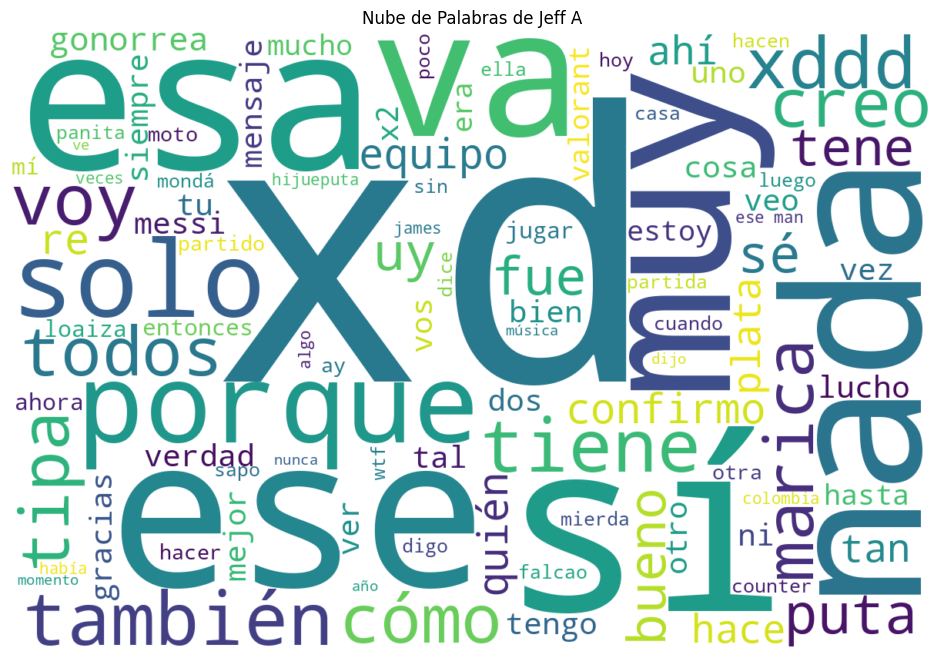

In [ ]:

# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
# Filtrar mensajes que no sean multimedia omitidos
patrones_multimedia = ['imagen omitida', 'Video omitido', 'audio omitido']
mensajes_df = df[~df['Mensaje'].str.contains('|'.join(patrones_multimedia), na=False)]

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s: len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s: len(s.split(' ')))

# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Definir las palabras a ignorar
stopwords = set(STOPWORDS)
stopwords.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es',
                  'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic', 'nos', 'ya', 'hay', 'esta',
                  'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https', 'media', 'omitido',
                  'y', 'mi', 'o', 'q', 'yo', 'al', 'jajajaja', 'jaja', 'jajaja', 'jajajajaja', 'jajaj', 'sticker', 'está'])

# Concatenar todos los mensajes en un solo texto
todos_los_mensajes = ' '.join(mensajes_df['Mensaje'].astype(str).tolist()).lower()

# Tokenizar el texto en palabras
palabras = todos_los_mensajes.split()

# Filtrar las palabras vacías
palabras_filtradas = [word for word in palabras if word not in stopwords]

# Contar la frecuencia de cada palabra
frecuencia_palabras = Counter(palabras_filtradas)

# ...
# Crear una nube de palabras global
wordcloud_global = WordCloud(width=1200, height=800,
                            background_color='white',
                            stopwords=stopwords,
                            min_font_size=15,  # Aumenta el tamaño mínimo de fuente
                            max_words=100).generate_from_frequencies(frecuencia_palabras)  # Limita la cantidad de palabras

# Mostrar la nube de palabras global
plt.figure(figsize=(12, 8))  # Aumenta el tamaño de la figura
plt.imshow(wordcloud_global, interpolation="bilinear")
plt.title("Nube de Palabras Global")
plt.axis("off")
plt.show()

# Iterar sobre cada miembro y crear una nube de palabras
for miembro in miembros:
    miembro_df = mensajes_df[mensajes_df['Miembro'] == miembro]
    total_palabras = ' '.join(miembro_df['Mensaje'].astype(str).tolist()).lower()

    wordcloud = WordCloud(width=1200, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=15,  # Aumenta el tamaño mínimo de fuente
                          max_words=100).generate(total_palabras)  # Limita la cantidad de palabras

    # Mostrar la nube de palabras del miembro
    plt.figure(figsize=(12, 8))  # Aumenta el tamaño de la figura
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Nube de Palabras de {miembro}")
    plt.axis("off")
    plt.show()

### Frases más usadas

In [ ]:

# Filtrar mensajes que contienen "editó este mensaje"
df = df[~df['Mensaje'].str.contains('editó este mensaje', na=False)]
df = df[~df['Mensaje'].str.contains('un arrendamiento', na=False)]
df = df[~df['Mensaje'].str.contains('omitido', na=False)]
df = df[~df['Mensaje'].str.contains('eliminó', na=False)]
df = df[~df['Mensaje'].str.contains('cambió la configuración', na=False)]
df = df[~df['Mensaje'].str.contains('@57', na=False)]
df = df[~df['Mensaje'].str.contains('ㅤ', na=False)]

# Definir un rango para los n-gramas (frases de 4 a 9 palabras para evitar frases muy largas)
ngram_range = range(4, 10)

# Contenedor para las frases más comunes por miembro
frases_por_miembro = {}
todas_las_frases_globales = []

miembros = df['Miembro'].unique()

for miembro in miembros:
    todas_las_frases_miembro = []

    # Filtrar mensajes del miembro actual
    mensajes_miembro = df[df['Miembro'] == miembro]['Mensaje'].str.lower()

    for mensaje in mensajes_miembro:
        # Asegurarse de que el mensaje no esté vacío y contenga texto alfabético
        if any(char.isalpha() for char in mensaje):
            palabras = mensaje.split()
            for n in ngram_range:
                # Limitar la longitud de cada n-grama a 50 caracteres
                ngramas = [' '.join(grams)[:50] for grams in ngrams(palabras, n)]
                todas_las_frases_miembro.extend(ngramas)
                todas_las_frases_globales.extend(ngramas)

    # Contar las frases y obtener las más comunes para el miembro actual
    frases_comunes_miembro = Counter(todas_las_frases_miembro).most_common(10)  # Ajusta este número para mostrar más/menos frases
    frases_por_miembro[miembro] = frases_comunes_miembro

# Contar las frases y obtener las más comunes a nivel global
frases_comunes_globales = Counter(todas_las_frases_globales).most_common(10)  # Ajusta este número para mostrar más/menos frases

# Crear gráfico de barras para las frases globales
frases_globales, conteos_globales = zip(*frases_comunes_globales)

plt.figure(figsize=(10, 6))
plt.barh(frases_globales, conteos_globales)
plt.xlabel('Frecuencia')
plt.ylabel('Frases')
plt.title('Frases más comunes a nivel global')
plt.gca().invert_yaxis()
plt.show()

# Crear gráficos de barras para cada miembro
for miembro, frases_comunes in frases_por_miembro.items():
    # Si no hay frases comunes, continúa con el siguiente miembro
    if not frases_comunes:
        continue

    frases, conteos = zip(*frases_comunes)

    plt.figure(figsize=(10, 6))
    plt.barh(frases, conteos)
    plt.xlabel('Frecuencia')
    plt.ylabel('Frases')
    plt.title(f'Frases más comunes de {miembro}')
    plt.gca().invert_yaxis()
    plt.show()
    plt.clf()

